<a href="https://colab.research.google.com/github/clomia/AIB-Section2-Project/blob/master/AI_03_%EC%9B%90%EC%A0%95%ED%9B%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install pandas_profiling
#!pip install category_encoders
#!pip install --upgrade pandas
#!pip install --upgrade pandas_profiling
#!pip install eli5
#!pip install pdpbox

## Dataset   
https://www.kaggle.com/brsdincer/alzheimer-features  
* Group: 치매유무  
* Age: 나이  
* EDUC: 교육받은기간(학업 년수)  
* SES: 사회경제적상태 (1~5) 높을수록 좋은거  
* MMSE: 간이정신상태검사(인지검사) (0 ~ 30점만점)  
* CDR: 치매의 정도를 나타내는 척도 (0 치매아님,0.5 매우경증,1 경증,2 중증도,3 중증)  
* 뇌 부피  
    * eTIV: 추정 두개골 내 부피  
    * nWBV: 전채 뇌 용적  
    * ASF: 해부학적 차이를 기반으로 스케일링 된 추정치  
  
뇌 부피 척도는 nWBV를 중점적으로 봐야할것 같다.     
  
참고자료(https://www.mdpi.com/2076-3425/9/9/212/htm)  
Mini-mental state exam (MMSE): (0,30). The MMSE is a 30-point questionnaire that has been shown to be valid and reliable in identifying dementia [7,23]. The variable was 56% complete (235 of 416). Missing values were imputed with the median. The MMSE was included in the non-imagery model.  
Atlas scaling factor (ASF): (0.88–1.56) (observed). The ASF is a one-parameter scaling factor that allows for comparison of the estimated total intracranial volume (eTIV) based on differences in human anatomy [19]. This variable was 100% complete (416 of 416) [10].  
Estimated total intracranial volume (eTIV): (1132–1992) mm3 [24]. The eTIV variable estimates intracranial brain volume. This variable was 100% complete (416 of 416).  
Normalized whole brain volume (nWBV): (0.64–0.90) mg (observed). This variable measures the volume of the whole brain. This variable was 100% complete (416 of 416).  

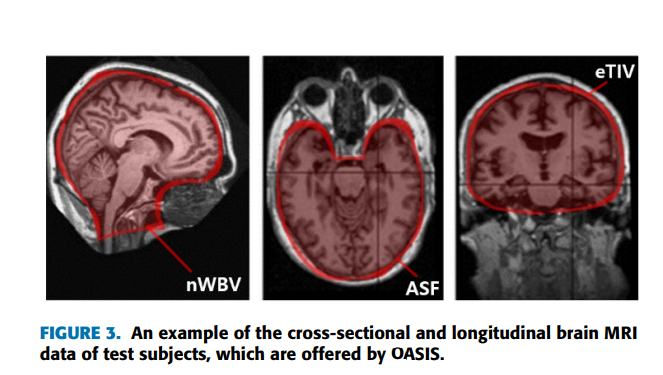

## 데이터 선정 이유 및 문제 정의  
데이터 선정 이유: 뇌과학 분야에 관심이 많아서 관련 데이터를 분석해보고 싶었습니다.  
  
머신러닝 문제 정의: Supervised Learning(지도학습) , 분류문제  
  
대상자의 인적사항과 MRI스캔을 통해서 대상자의 치매 여부를 예측하는 모델을 만들고 싶습니다.  



## 데이터를 이용한 가설 및 평가지표, 베이스라인 선택  
이 데이터를 이용해서 치매 여부와 다른 피처들간의 상관관계를 파악할 수 있을것 같습니다.  
예를 들어서 "성별,나이,교육수준,사회경제적 상태가 치매여부에 얼마나 영향을 미치는가?"  
라는 질문에 대한 인사이트를 얻을 수 있습니다.   
target으로는 치매 여부를 나타내는 Group 특성을 사용합니다.  


## EDA와 전처리    

In [2]:
import pandas as pd
import numpy as np

data = pd.read_csv('https://drive.google.com/uc?export=download&id=1hu4cXJaPvUEAAgOwXZwux42Uz3vnmH0o')
data.head()

,Group,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,M,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,Nondemented,M,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,Demented,M,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,Demented,M,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,Demented,M,80,12,NaN,22.0,0.5,1698,0.701,1.034


CDR(치매를 나타내는 척도)와 MMSE(간이 치매검사)는 만들고자 하는 모델의 input과 거리가 멀고  
치매 여부와 직결되서 target과 높은 상관관계를 가지고 있기 때문에 데이터에서 제외합니다.  
아래 그림은 두 척도를 포함해서 RandomForest모델을 만들었을때의 특성 중요도를 보여줍니다

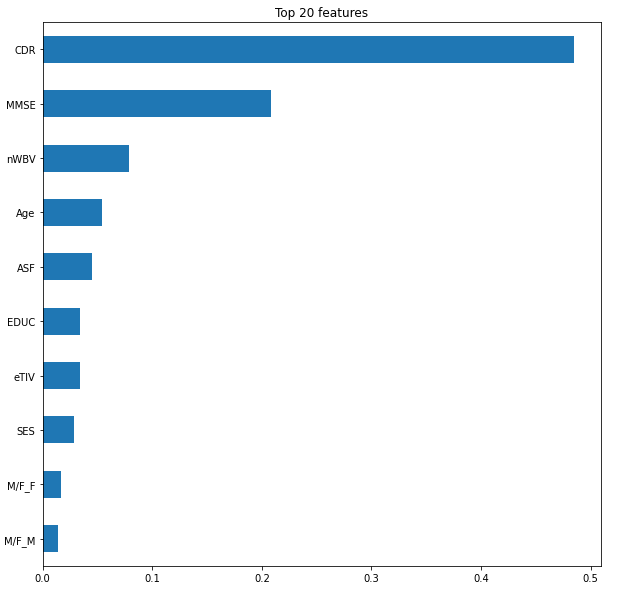

In [3]:
print(data.shape)
data.drop(['CDR','MMSE'],axis=1,inplace=True)
print(data.shape)

(373, 10)
(373, 8)


#### Baseline 모델 선정  
기준모델은 최빈값인 Nondemented으로 합니다.  
(이후, Demented가 아닌 값 Converted는 Nondemented로 변환합니다.)

In [4]:
data['Group'].value_counts(normalize=True)

Nondemented    0.509383
Demented       0.391421
Converted      0.099196
Name: Group, dtype: float64

숫자컬럼을 숫자타입으로 변환합니다.  

In [5]:
numerices = ['Age','EDUC','SES','eTIV','nWBV','ASF']
for feature in numerices:
    data[feature] = pd.to_numeric(data[feature])

copy_data = data.copy()
data.dtypes

Group     object
M/F       object
Age        int64
EDUC       int64
SES      float64
eTIV       int64
nWBV     float64
ASF      float64
dtype: object

SES에 결측치 19개 , MMSE에 결측치 2개  

In [6]:
data.isnull().sum()

Group     0
M/F       0
Age       0
EDUC      0
SES      19
eTIV      0
nWBV      0
ASF       0
dtype: int64

#### SES 결측치 처리  
평균과 표준편차를 모방한 데이터셋을 만들어서 결측치를 대체합니다.  

In [7]:
round_int = lambda number:int(round(number,0))

ses = data['SES']
MISSING_VALUE_COUNT = 19

data_info = {
    '평균':round_int(np.mean(ses)),
    '분산':round_int(np.var(ses)),
    '표준편차':round_int(np.std(ses)),
}

def faking():
    """ 결측치를 대체할 데이터셋을 생성합니다. """

    make_fake_data = lambda : round_int(data_info['표준편차'] * np.random.randn() + data_info['평균'])
    fake_data = [ make_fake_data() for _ in range(MISSING_VALUE_COUNT) ]

    #SES점수에는 0점이 없습니다
    return fake_data if not 0 in fake_data else faking()

# 데이터 셈플 생성
fake_data = faking()
def fake_data_apply(value):
    """ 결측치를 셈플데이터로 대체 """
    try:
        return int(value)
    except:
        return fake_data.pop()

data['SES'] = ses.apply(fake_data_apply)

#### 결측치 처리 확인  

In [8]:
data.isnull().sum()

Group    0
M/F      0
Age      0
EDUC     0
SES      0
eTIV     0
nWBV     0
ASF      0
dtype: int64

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,373.0,77.013405,7.640957,60.000,71.000,77.000,82.000,98.000
EDUC,373.0,14.597855,2.876339,6.000,12.000,15.000,16.000,23.000
SES,373.0,2.431635,1.128214,1.000,1.000,2.000,3.000,5.000
eTIV,373.0,1488.128686,176.139286,1106.000,1357.000,1470.000,1597.000,2004.000
nWBV,373.0,0.729568,0.037135,0.644,0.700,0.729,0.756,0.837
ASF,373.0,1.195461,0.138092,0.876,1.099,1.194,1.293,1.587


#### Pandas Profiling

In [10]:
from pandas_profiling import ProfileReport

ProfileReport(data)

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### EDA를 통한 짧은 인사이트  


nWBV(전체 뇌 용적)은 나이가 듦에 따라서 줄어드는 양상을 보입니다.  
하지만 다른 뇌 부피 척도(eTIV,ASF)는 별다른 상관관계가 없어보입니다. 

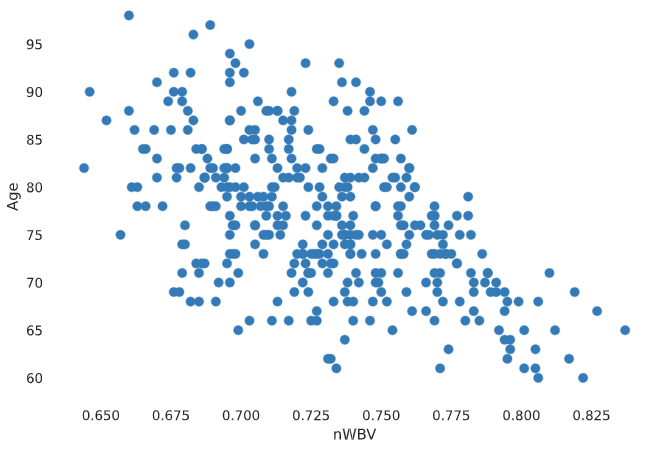

또한 nWBV(전체 뇌 용적)은 작을수록 간이 정신상태검사(간이 치매검사 MMSE)인지상태측정 점수가 낮은 셈플이 많이 분포합니다.  

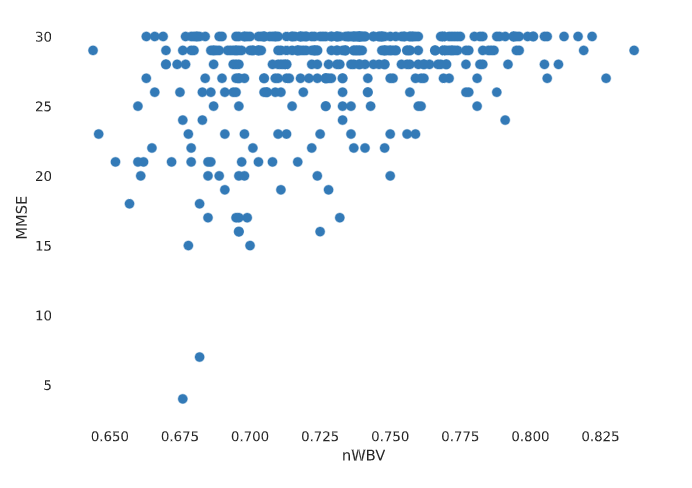

ASF가 늘어나면 eTIV가 줄어드는 양상을 보입니다.  
(단순히 해석해서 사람 뇌 부피는 다 비슷하기 때문에 수평단면이 넓을수록 수직단면이 작아지는것 같습니다.)  
하지만 두 척도의 상관관계가 선형보다 약간의 로그관계로 나타나는 점이 신기합니다.  
한쪽 척도값이 양의 방향으로 극단적이게 치우칠수록 다른 척도값이 음의 방향으로 많이 치우치는것 같아 보입니다.  

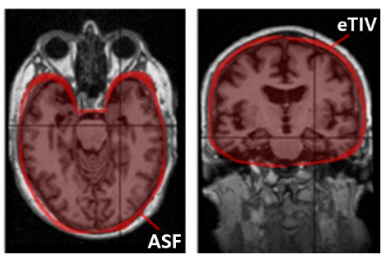

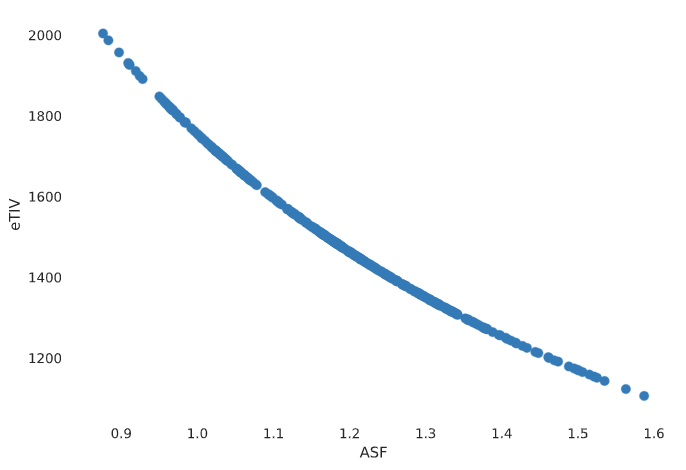

target feauture binary classification  
치매 , 치매 아님으로 이분화 하였습니다.  

In [11]:
print(set(data['Group'])) 
data['Group'] = data['Group'].apply(lambda x: 'Nondemented' if x == 'Converted' else x )
print(set(data['Group']))

{'Demented', 'Nondemented', 'Converted'}
{'Demented', 'Nondemented'}


치매 유무에 따라서 binary classification

In [12]:
data['Group'] = data['Group'].apply(lambda x: 1 if x == 'Demented' else 0 )
data = data.rename({'Group':'Demented'},axis=1)
data.head()

,Demented,M/F,Age,EDUC,SES,eTIV,nWBV,ASF
0,0,M,87,14,2,1987,0.696,0.883
1,0,M,88,14,2,2004,0.681,0.876
2,1,M,75,12,2,1678,0.736,1.046
3,1,M,76,12,1,1738,0.713,1.010
4,1,M,80,12,3,1698,0.701,1.034


테스크를 수행한 후 Data Leakage가 존재합니다.  
타겟 특성을 binary classification할때 Converted값이 다 Nondemented로 바뀌었기 때문입니다.  
Group지표에서 Converted가 정확히 무엇을 의미하는지 모르기 때문에 파악하지 못한 Data Leakage가 생길것으로 예상됩니다.    

## 머신러닝 방식 적용 및 교차검증

In [13]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data,test_size=0.3)
train, valid = train_test_split(train,test_size=0.3)

train.shape , valid.shape , test.shape

((182, 8), (79, 8), (112, 8))

In [14]:
target = 'Demented'

X = lambda df:df.drop(target,axis=1)
y = lambda df:df[target]

X_train,y_train = X(train),y(train)
X_valid,y_valid = X(valid),y(valid)
X_test,y_test = X(test),y(test)

**OneHotEncoding**

In [15]:
from category_encoders import OneHotEncoder

encoder = OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_valid = encoder.transform(X_valid)
X_test = encoder.transform(X_test)

X_train.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,M/F_F,M/F_M,Age,EDUC,SES,eTIV,nWBV,ASF
81,1,0,71,16,1,1289,0.771,1.362
9,0,1,85,12,4,1699,0.705,1.033
293,1,0,91,18,2,1714,0.741,1.024
345,0,1,73,16,4,1803,0.731,0.973
368,0,1,82,16,1,1693,0.694,1.037


#### Linear / Tree-based / Ensemble 모델을 학습하세요. 

Linear 모델인 Logistic Regression 모델 학습

In [16]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(max_iter=1000,random_state=4)
logistic.fit(X_train, y_train)
logistic.score(X_valid, y_valid)

0.7974683544303798

Tree-based 모델인 Decision Tree 학습

In [17]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(random_state=4, criterion='entropy')
decision_tree.fit(X_train,y_train)
decision_tree.score(X_valid,y_valid)

0.759493670886076

Ensemble 모델인 RandomForest학습

In [18]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_jobs=-1, random_state=4, oob_score=True)
random_forest.fit(X_train,y_train)
random_forest.score(X_valid,y_valid)

0.7721518987341772

모두 Nondemented로 예측하는 Baseline 모델의 정확도는 0.67입니다.

In [19]:
valid['Demented'].value_counts(normalize=True)

0    0.64557
1    0.35443
Name: Demented, dtype: float64

#### Cross Validation  
  
점수가 높은 Logistic 모델과 Random Forest모델을 최종 모델로 선정  

In [20]:
from sklearn.model_selection import cross_val_score, cross_validate

logistic_score = cross_val_score(logistic, X_train, y_train, scoring='accuracy', cv=5)
decision_tree_score = cross_val_score(decision_tree, X_train, y_train, scoring='accuracy', cv=5)
random_forest_score = cross_val_score(random_forest, X_train, y_train, scoring='accuracy', cv=5)

f'Logistic={np.mean(logistic_score):.4f} , Decision Tree={np.mean(decision_tree_score):.4f} , Random Forest={np.mean(random_forest_score):.4f}'

'Logistic=0.6039 , Decision Tree=0.6925 , Random Forest=0.7529'

특성 중요도 확인  

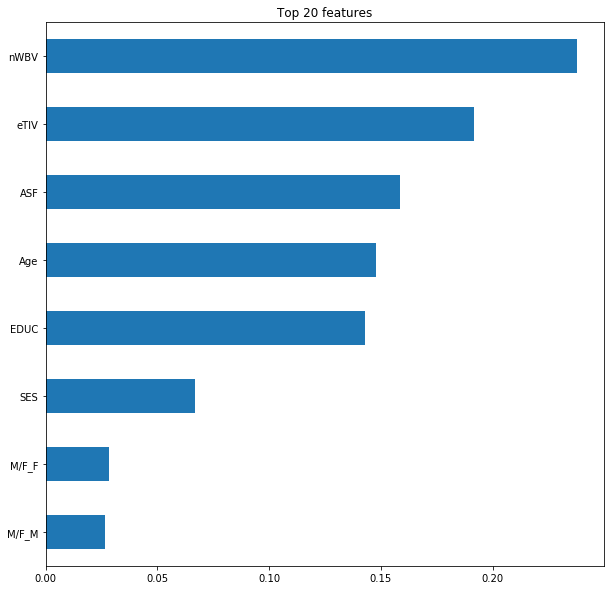

In [21]:
importances = pd.Series(random_forest.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

#### Hyperparameter tuning

검증셋과 훈련셋을 합쳐서 train,test로만 분류

In [22]:
X_train = pd.concat([X_train,X_valid])
y_train = pd.concat([y_train,y_valid])
X_train.shape , y_train.shape

((261, 8), (261,))

##### RandomForestClassifier

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

dists = {
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, 30,50,None], 
    'max_features': uniform(0, 1) # max_features
}

random_forest_clf = RandomizedSearchCV(
    RandomForestClassifier(), 
    param_distributions=dists, 
    n_iter=170, 
    cv=4, 
    scoring='f1',  
    verbose=1,
    n_jobs=-1
)

random_forest_clf.fit(X_train, y_train);

Fitting 4 folds for each of 170 candidates, totalling 680 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 680 out of 680 | elapsed:  4.1min finished


In [24]:
print('최적 하이퍼파라미터: ', random_forest_clf.best_params_)
print('F1: ', random_forest_clf.best_score_)

최적 하이퍼파라미터:  {'max_depth': 50, 'max_features': 0.2767173790560955, 'n_estimators': 351}
F1:  0.7490230134607034


##### LogisticRegression

뇌의 부피를 나타내는 척도인 eTIV,nWBV,ASF에서 다중공산성 문제가 있을 수도 있기 때문에.  
class weight을 0.4,0.6,0.4으로 줘보았습니다

In [25]:
dists = {
    'C': list(range(10,100,10))+[0.001,0.1,1,10,1000], 
    'class_weight': (None,'balanced',{
        'M/F':1,
        'Age':1,
        'EDUC':1,
        'SES':1,
        'eTIV':0.4,
        'nWBV':0.6,
        'ASF':0.4,
    }), 
    'max_iter':(50,500,1000,2000,3000),
}

logistic_clf = RandomizedSearchCV(
    LogisticRegression(), 
    param_distributions=dists, 
    n_iter=170, 
    cv=4, 
    scoring='f1',  
    verbose=1,
    n_jobs=-1
)

logistic_clf.fit(X_train, y_train);

Fitting 4 folds for each of 170 candidates, totalling 680 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 680 out of 680 | elapsed:   14.7s finished


In [26]:
print('최적 하이퍼파라미터: ', logistic_clf.best_params_)
print('F1: ', logistic_clf.best_score_)

최적 하이퍼파라미터:  {'max_iter': 500, 'class_weight': 'balanced', 'C': 90}
F1:  0.6770015698587126


#### 최종 모델의 test점수(accuracy)  
점수가 높은 Random Forest 모델을 최종 모델로 합니다.    

In [27]:
from sklearn.metrics import accuracy_score

random_forest = random_forest_clf.best_estimator_
logistic = logistic_clf.best_estimator_

random_forest_pred = random_forest.predict(X_test)
logistic_pred = logistic.predict(X_test)

random_forest_accuracy = accuracy_score(y_test,random_forest_pred)
logistic_accuracy = accuracy_score(y_test,logistic_pred)

print(f'Random Forest Accuracy:{random_forest_accuracy:.4f} , Logistic Accuracy:{logistic_accuracy:.4f}')

Random Forest Accuracy:0.8571 , Logistic Accuracy:0.6161


**baseline 모델과 비교**  
  
학습한 모델은 BaseLine 모델에 비해 유의미하게 높은 정확도를 보입니다.  

In [28]:
baseline = [ 0 for _ in range(len(y_test)) ]
accuracy_score(y_test,baseline)

0.625

## 머신러닝 모델 해석

#### PDP Plot

nWBV(전체 뇌 용적)이 클수록 치매일 확률이 낮아집니다.  

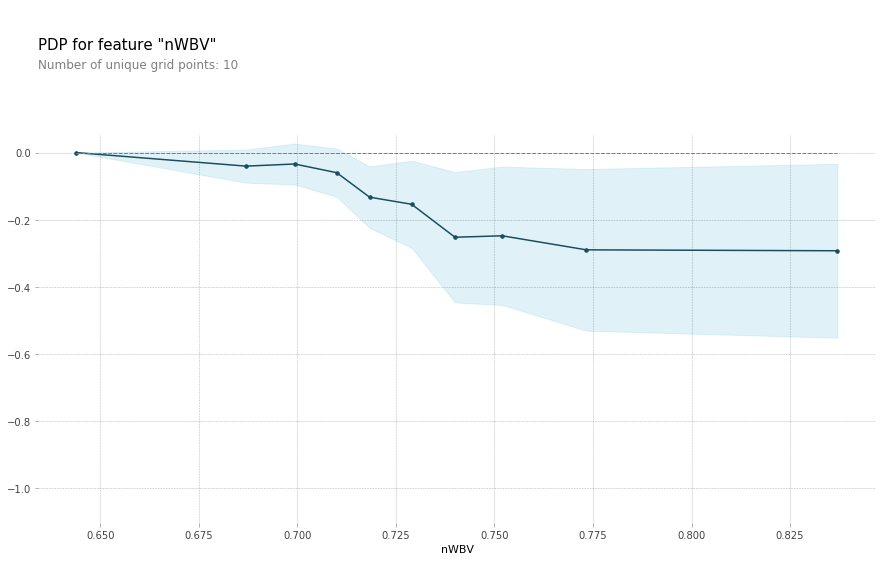

In [30]:
from pdpbox.pdp import pdp_isolate, pdp_plot

def pdp(feature):
    isolated = pdp_isolate(
        model=random_forest, 
        dataset=X_test, 
        model_features=X_test.columns, 
        feature=feature,
    )
    pdp_plot(isolated, feature_name=feature);

pdp('nWBV')

ASF 값이 커질수록 치매일 확률도 높다고 예측합니다.  

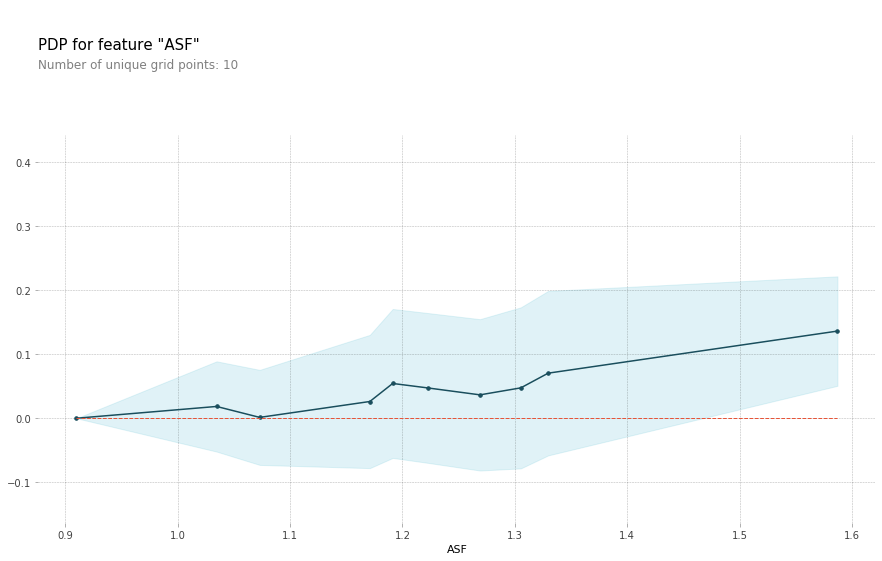

In [31]:
pdp('ASF')

eTIV값이 높아질수록 치매일 확률이 낮다고 예측하는 양상을 보입니다.  

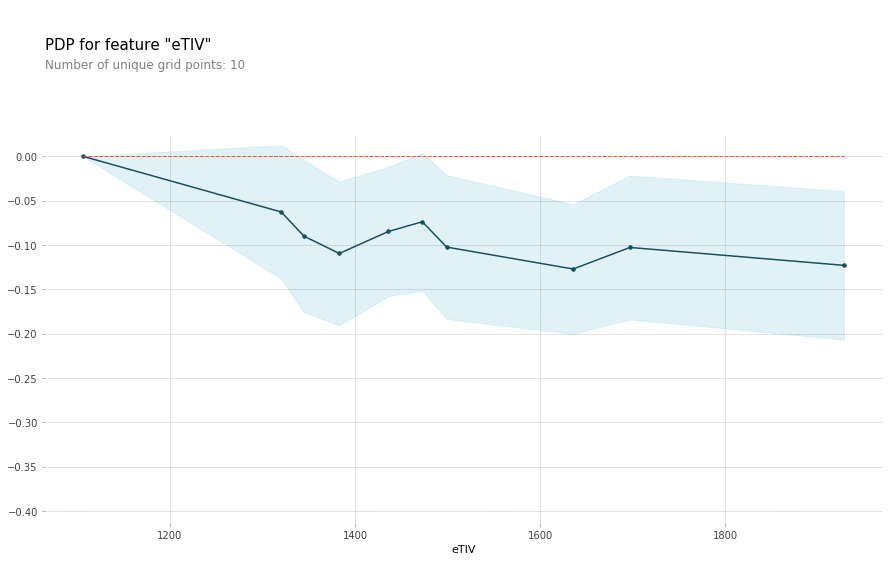

In [33]:
pdp('eTIV')

사회경제적상태가 좋을수록 치매에 걸릴 확률도 증가한다고 예측합니다.  

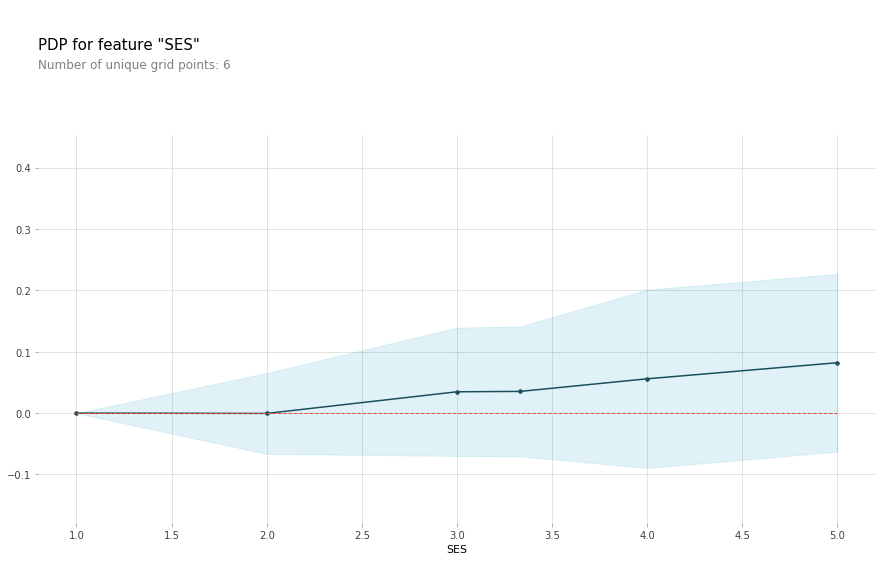

In [35]:
pdp('SES')

교육받은 기간이 길 수록 치매에 걸릴 확률도 낮다고 예측합니다.  

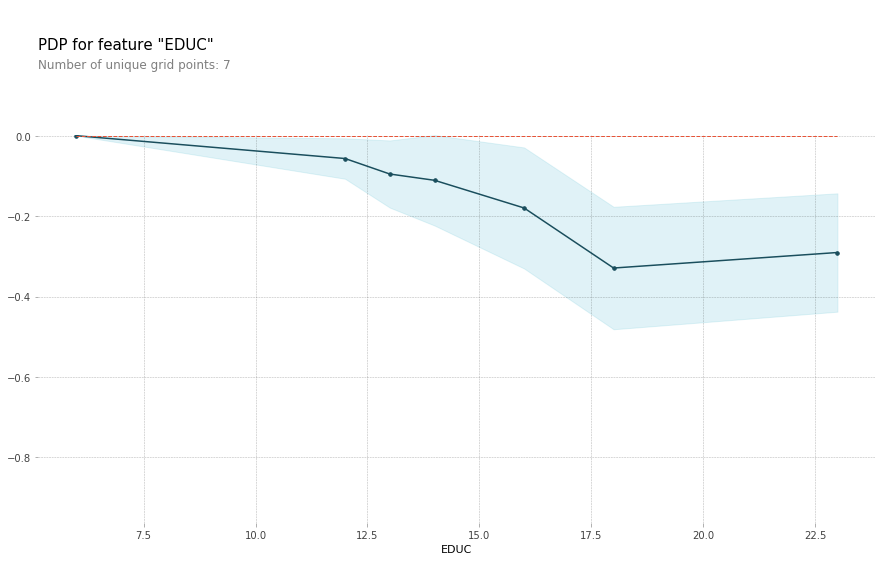

In [36]:
pdp('EDUC')

여자인 경우보다 남자인 경우 치매일 가능성이 더 높다고 예측합니다.  

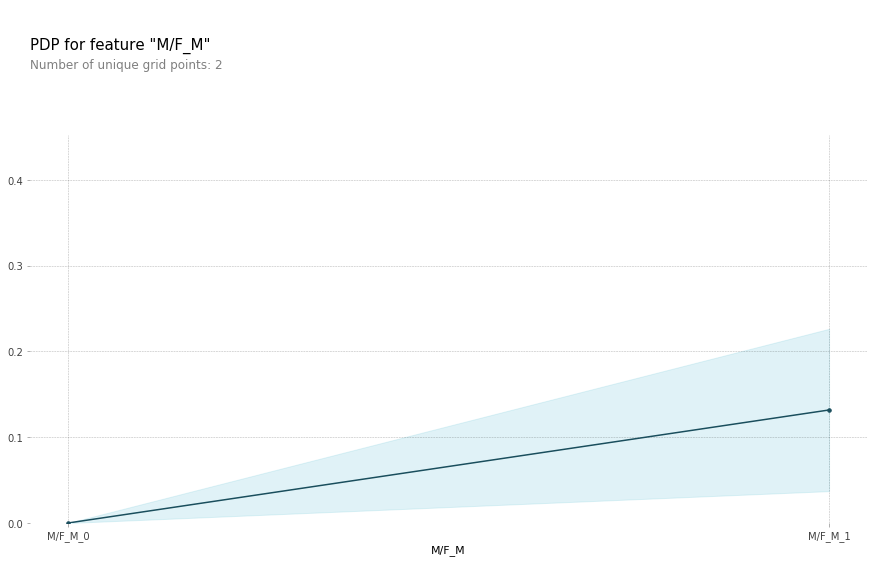

In [42]:
pdp('M/F_M')

신기하게도 연령이 높을수록 오히려 치매일 확률이 낮다고 예측합니다.  

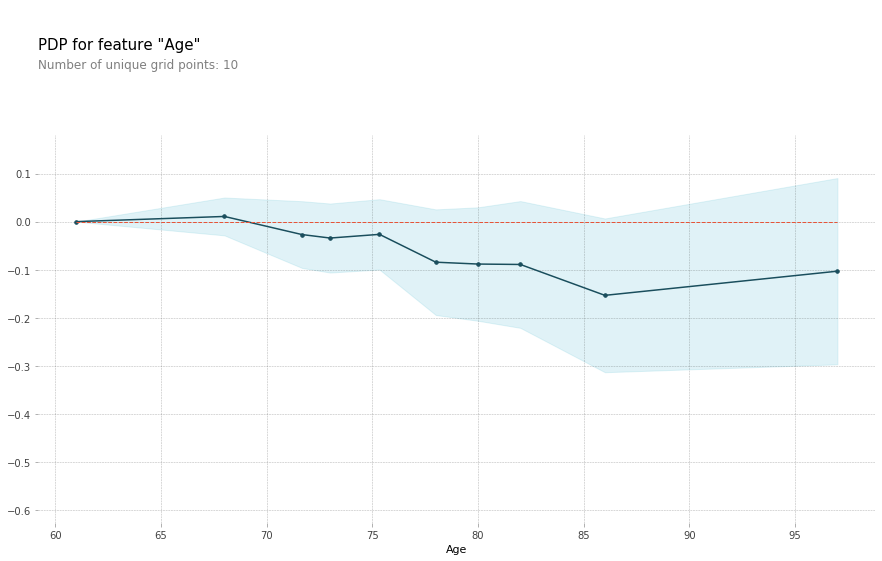

In [44]:
pdp('Age')

### 특성 중요도

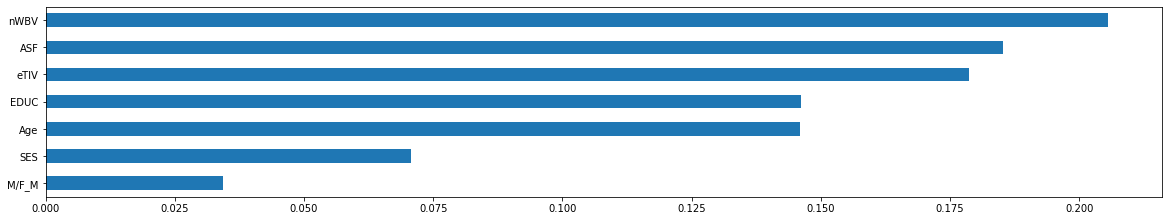

In [50]:
importances_ord = pd.Series(random_forest.feature_importances_, X_train.columns)
plt.figure(figsize=(20,n/2))
importances_ord.sort_values()[-n:].plot.barh();

### 모델 시각화

In [58]:
from sklearn.tree import export_graphviz

# .dot 파일로 export 해줍니다
export_graphviz(random_forest.estimators_[3], out_file='tree.dot')

# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'decistion-tree.png', '-Gdpi=600'])

# jupyter notebook에서 .png 직접 출력
from IPython.display import Image
Image(filename = 'decistion-tree.png')

estimator = random_forest.estimators_[3]

export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X_test.columns,
                class_names = 'Demented',
                max_depth = 3, # 표현하고 싶은 최대 depth
                precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True, # 박스의 모양을 둥글게
               )

## 치매여부 프로그램

In [68]:
dct = {'M/F_F':1,
'M/F_M':0,
'Age':71,
'EDUC':16,
'SES':1,
'eTIV':1289,
'nWBV':0.771,
'ASF': 1.362}

#random_forest.predict([list(dct.values())])[0]
random_forest.predict([list(dct.values())])

array([0])

In [70]:
while True:
    dist = {}
    if input('성별(남/여): ') is '남':
        dist['M/F_M'] = 1
        dist['M/F_F'] = 0
    else:
        dist['M/F_M'] = 0
        dist['M/F_F'] = 1
    
    for feature in ('Age','EDUC','SES','eTIV','nWBV','ASF'):
        dist[feature] = input(f'{feature}: ')
        
    is_demented = random_forest.predict([list(dct.values())])[0]
    if is_demented:
        print('치매일 확률이 높습니다.')
    else:
        print('치매가 아닐 확률이 높습니다. ')
    


KeyboardInterrupt: ignored